In [2]:
from __future__ import annotations
import catboost
import collections
import dataclasses
import functools
import io
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
# import pymorphy3
import random
import re
import requests
import scipy
import sklearn.cluster
import sklearn.datasets
import sklearn.decomposition
import sklearn.linear_model
import subprocess
import string
import sys
import tokenizers
import torch
import torch.nn as nn
import transformers
import time
import tqdm
import typing as tp
import urllib

In [3]:
def run_executable(path: str, arguments: str = "", input_: str = "") -> str:
    completed_process = subprocess.run(
        [path, arguments], input=input_, text=True, capture_output=True
    )
    output = completed_process.stdout
    return output


def factorial(n):
    factorial = 1
    for i in range(1, n + 1):
        factorial *= i
    return factorial


def get_pairwise_difference_matrix(array):
    """Returns matrix M[i, j] = a[i] - a[j]."""
    pairwise_difference_matrix = array[:, None] - array[None, :]
    return pairwise_difference_matrix


def permute(array, first, second):
    array[first], array[second] = array[second], array[first]

def get_yadisk_download_url(
    yadisk_url: str,
    base_url="https://cloud-api.yandex.net/v1/disk/public/resources/download?",
) -> str:
    final_url = base_url + urllib.parse.urlencode(dict(public_key=yadisk_url))
    response = requests.get(final_url)
    download_url = response.json()["href"]
    return download_url

def write_url_response_content_to_file(url: str, filename: str) -> None:
    download_response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(download_response.content)
        
def set_torch_device_order_pci_bus():
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

In [4]:
CPP_DIR = "/Users/dimakoshman/CLionProjects/coderun_ml/cmake-build-debug"

In [5]:
@dataclasses.dataclass
class Timer:
    enter_time: list[float] = dataclasses.field(default_factory=list)
    exit_time: list[float] = dataclasses.field(default_factory=list)

    def __enter__(self):
        self.enter_time.append(time.time())
        return self

    def __exit__(self, *args, **kwargs):
        self.exit_time.append(time.time())

    def wrap(self, function: tp.Callable) -> tp.Callable:
        @functools.wraps(function)
        def wrapper(*args, **kwargs):
            with self:
                return function(*args, **kwargs)

        return wrapper

    def stats(self) -> dict[str, float]:
        timings = [a - b for a, b in zip(self.exit_time, self.enter_time, strict=True)]
        stats = dict(mean=np.mean(timings), std=np.std(timings), max=max(timings))
        return stats

    def formatted_stats(
        self, time_unit: tp.Literal["ms", "s"] = "ms", precision: int = 3
    ) -> str:
        formatted_stats: list[str] = []
        for k, v in self.stats().items():
            match time_unit:
                case "ms":
                    v *= 1000
                case "s":
                    pass
                case _:
                    raise ValueError(f"Unknown time unit {time_unit}.")
            formatted_stats.append(f"\t{k}:\t{v:.{precision}f} {time_unit}")

        formatted_stats = "\n".join(formatted_stats)
        return formatted_stats

In [6]:
@dataclasses.dataclass
class Input:
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        raise NotImplementedError


@dataclasses.dataclass
class Output:
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        raise NotImplementedError

    def __str__(self) -> str:
        raise NotImplementedError
        
    def __eq__(self, output_: Output) -> bool:
        raise NotImplementedError


def generate_random_input(test_case: int) -> Input | tp.Tuple[Input, Output]:
    raise NotImplementedError


def generate_stress_input() -> Input:
    raise NotImplementedError


def brute_force_solve(input_: Input) -> Output:
    raise NotImplementedError


def solve(input_: Input) -> Output:
    raise NotImplementedError


def cpp_solve(input_: Input) -> Output:
    raise NotImplementedError
    
    
def is_correct(input_: Input, output: Output, expected_output: Output|None):
    if expected_output is not None:
        try:
            return expected_output == output
        except NotImplementedError:
            pass
    raise NotImplementedError

    
def check(
    solve: tp.Callable,
    input_: Input | str,
    expected_output: Output | str | None = None,
) -> None:
    if isinstance(input_, str):
        input_ = Input.from_string_io(io.StringIO(input_))

    output = solve(input_)

    if isinstance(expected_output, str):
        expected_output = Output.from_string_io(io.StringIO(expected_output))
    if not is_correct(input_, output, expected_output):
        message = f"Wrong answer, input:\n{input_}\nOutput:\n{output}"
        if expected_output is not None:
            message += f"\nExpected output:\n{expected_output}"
        raise RuntimeError(message)

    try:
        brute_force_output = brute_force_solve(input_)
    except NotImplementedError:
        pass
    else:
        if not is_correct(input_, output, brute_force_output):
            raise RuntimeError(
                f"Wrong answer, brute force output:\n{brute_force_output}\nReceived:\n{output}"
            )

    try:
        cpp_output = cpp_solve(input_)
    except NotImplementedError:
        pass
    else:
        if not is_correct(input_, output, cpp_output):
            raise RuntimeError(
                f"Wrong answer, cpp output:\n{cpp_output}\nReceived:\n{output}"
            )


def simple_test():
    #     check(solve, """""", """""")
    #     check(solve, """""", """""")
    #     check(solve, """""", """""")

    print("Simple tests OK")


def random_test():
    random_tests_timer = Timer()
    timed_solve = random_tests_timer.wrap(solve)

    for test_case in range(100):
        match generate_random_input(test_case):
            case input_, expected_output:
                pass
            case input_:
                expected_output = None

        check(solve=timed_solve, input_=input_, expected_output=expected_output)

    print(f"Random tests OK\n{random_tests_timer.formatted_stats()}")


def stress_test():
    stress_tests_timer = Timer()
    timed_solve = stress_tests_timer.wrap(solve)

    for _ in range(10):
        input_ = generate_stress_input()
        check(solve=timed_solve, input_=input_)

    print(f"Stress tests OK\n{stress_tests_timer.formatted_stats()}")


def test():
    simple_test()
    random_test()
    stress_test()


def main():
    print(solve(Input.from_string_io(sys.stdin)))

### [Интерполяция](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/interpolation?currentPage=2&pageSize=10&rowNumber=19)

In [49]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.linear_model
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    x: tp.List[tp.List[float]]
    y: tp.List[float]
    test_x: tp.List[tp.List[float]]
    
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        x = []
        y = []
        for _ in range(1000):
            line = list(map(float, string_io.readline().split()))
            x.append(line[:-1])
            y.append(line[-1])
            
        test_x = []
        for _ in range(1000):
            test_x.append(list(map(float, string_io.readline().split())))
            
        input_ = Input(x=x, y=y, test_x=test_x)
        return input_


@dataclasses.dataclass
class Output:
    test_y: tp.List[float]
        
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        test_y = []
        for _ in range(1000):
            test_y.append(float(string_io.readline()))
            
        output = Output(test_y=test_y)
        return output

    def __str__(self) -> str:
        string = "\n".join(map(str, self.test_y))
        return string

    def __eq__(self, output: Output)-> bool:
        return np.isclose(self.test_y, output.test_y).all()
        
    
def solve(input_: Input) -> Output:
    x = np.array(input_.x)
    y = np.array(input_.y)
    test_x = np.array(input_.test_x)
    
    pipeline = sklearn.pipeline.Pipeline([
        ("polynomial_features", sklearn.preprocessing.PolynomialFeatures()),
        ("linear_regression", sklearn.linear_model.LinearRegression(fit_intercept=False)),]
    )
    pipeline.fit(x, y)
    test_y = pipeline.predict(test_x)
    output = Output(test_y=test_y)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [50]:
def generate_random_input(test_case: int) -> Input | tp.Tuple[Input, Output]:
    parameters = np.random.uniform(-10, 10, size=21)
    x = np.random.uniform(-1000, 1000, size=(1000, 5))
    test_x = np.random.uniform(-1000, 1000, size=(1000, 5))
    
    polynomial_features = sklearn.preprocessing.PolynomialFeatures()
    
    y = polynomial_features.fit_transform(x) @ parameters
    lines = []
    for i in range(1000):
        lines.append("\t".join(map(str, list(x[i]) + [y[i]])))
    for i in range(1000):
        lines.append("\t".join(map(str, test_x[i])))
    string = "\n".join(lines)
    input_ = Input.from_string_io(io.StringIO(string))
    
    test_y = polynomial_features.transform(test_x) @ parameters
    output = Output(test_y=test_y)
    return input_, output
    

In [51]:
random_test()

Random tests OK
	mean:	48.628 ms
	std:	34.526 ms
	max:	189.299 ms


### [D-CoV-3999](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/dcov3999?currentPage=2&pageSize=10&rowNumber=20)

In [115]:
from __future__ import annotations
import dataclasses
import heapq
import io
import numpy as np
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    is_sick: tp.List[int]
    meetings: tp.List[tp.List[int]]
    
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_workers = int(string_io.readline())
        is_sick = list(map(int, string_io.readline().split()))
        meetings = []
        for _ in range(n_workers):
            m = list(map(int, string_io.readline().split()))
            meetings.append(m[1:])
            
        input_ = Input(is_sick=is_sick, meetings=meetings)
        return input_


@dataclasses.dataclass
class Output:
    is_sick: tp.List[int]
        
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        is_sick = list(map(int, string_io.readline().split()))
        output = Output(is_sick=is_sick)
        return output

    def __str__(self) -> str:
        string = " ".join(map(str, self.is_sick))
        return string

    def __eq__(self, output: Output)-> bool:
        return all(i == j for i, j in zip(self.is_sick, output.is_sick))
        
    
def solve(input_: Input) -> Output:
    is_sick = np.array(input_.is_sick, dtype=bool)
    next_meeting_heap = []
    meetings = input_.meetings
    for i, meeting in enumerate(meetings):
        meetings[i] = sorted(meeting, reverse=True)
        if meetings[i]:
            next_meeting = meetings[i].pop()
            heapq.heappush(next_meeting_heap, (next_meeting, i))
    
    while next_meeting_heap:
        meeting = next_meeting_heap[0][0]
        attended_workers = []
        infect = False
        while next_meeting_heap and next_meeting_heap[0][0] == meeting:
            _, worker = heapq.heappop(next_meeting_heap)
            attended_workers.append(worker)
            if is_sick[worker]:
                infect = True
            if meetings[worker]:
                next_meeting = meetings[worker].pop()
                heapq.heappush(next_meeting_heap, (next_meeting, worker))
        
        if infect:
            is_sick[attended_workers] = True
    
    output = Output(is_sick=is_sick.astype(int))
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [116]:
def simple_test():
    check(solve, """4
    1 0 0 1
    1 1
    1 1
    0
    0""", """1 1 0 1""")

    print("Simple tests OK")

In [117]:
simple_test()

Simple tests OK


### [Канатная дорога](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/cable-car?currentPage=3&pageSize=10&rowNumber=21)

In [298]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    mountains: tp.List[tp.Tuple[int, int]]
    
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_mountains = int(string_io.readline())
        mountains = []
        for _ in range(n_mountains):
            x, y = map(float, string_io.readline().split())
            mountains.append((x, y))
            
        input_ = Input(mountains=mountains)
        return input_


@dataclasses.dataclass
class Output:
    total_length: float

    def __str__(self) -> str:
        string = str(self.total_length)
        return string
        
    
def solve(input_: Input) -> Output:
    total_length = 0
    decreasing_mountains = []
    for i, ((prev_x, prev_y), (x, y)) in enumerate(zip([(0, 0)] + input_.mountains, input_.mountains)):
        total_length += ((x - prev_x)**2 + (y - prev_y)**2)**0.5
        
        while decreasing_mountains and input_.mountains[decreasing_mountains[-1]][1] <= y:
            if decreasing_mountains[-1] < i - 1:
                from_x, from_y = input_.mountains[decreasing_mountains[-1]]
                total_length += ((x - from_x)**2 + (y - from_y)**2)**0.5
            decreasing_mountains.pop()
            
        decreasing_mountains.append(i)
            
    output = Output(total_length=total_length)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [302]:
print(solve(Input.from_string_io(io.StringIO("""6
3 2
5 1
7 4
9 3
11 7
12 1"""))))

31.710272946224936


### [Оптимальная константа](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/optimal-constant?currentPage=3&pageSize=10&rowNumber=22)

In [339]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    x: tp.List[int]
    
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n = int(string_io.readline())
        x = []
        for _ in range(n):
            x.append(int(string_io.readline()))
            
        input_ = Input(x=x)
        return input_


@dataclasses.dataclass
class Output:
    mse_estimate: float
    mae_estimate: float
    mape_estimate: float
        
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        mse_estimate, mae_estimate, mape_estimate = map(float, string_io.read().split())
        output = Output(mse_estimate, mae_estimate, mape_estimate)
        return output

    def __str__(self) -> str:
        string = "\n".join(map(str, [self.mse_estimate, self.mae_estimate, self.mape_estimate]))
        return string

    def __eq__(self, output: Output)-> bool:
        raise NotImplementedError
    
def solve(input_: Input) -> Output:
    x = np.array(input_.x)
    x.sort()
    mse_estimate = x.mean()
    mae_estimate = x[len(x) // 2]
    harmonic = (1 / x).sum()
    harmonic_prefix_sum = 0
    i = 0
    while 2 * harmonic_prefix_sum < harmonic:
        harmonic_prefix_sum += 1 / x[i]
        i += 1
    mape_estimate = x[i - 1]
    output = Output(mse_estimate, mae_estimate, mape_estimate)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [340]:
def is_correct(input_: Input, output: Output, expected_output: Output|None):
    if expected_output is None:
        raise NotImplementedError
        
    x = np.array(input_.x)
    mse = ((x - output.mse_estimate)**2).sum()
    mae = np.abs(x - output.mae_estimate).sum()
    mape = np.abs((x - output.mape_estimate) / x).sum()
    
    expected_mse = ((x - expected_output.mse_estimate)**2).sum()
    expected_mae = np.abs(x - expected_output.mae_estimate).sum()
    expected_mape = np.abs((x - expected_output.mape_estimate) / x).sum()
    
    return np.isclose([mse, mae, mape], [expected_mse, expected_mae, expected_mape]).all()
    
    
def simple_test():
    check(solve, """5
        6
        4
        3
        5
        3""", """4.2
        4
        3""")
    
    check(solve, """4
        10
        100
        10
        100""", """55
        100
        10""")

    check(solve, """5
        10
        1
        3
        4
        2""", """4
        3
        2""")

    print("Simple tests OK")

In [341]:
simple_test()

Simple tests OK


### [Исчезнувшая](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/in-search-of-kitty?currentPage=3&pageSize=10&rowNumber=23)

In [557]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    template: np.ndarray
    photo: np.ndarray
    
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n, m = map(int, string_io.readline().split())
        template = np.zeros((n, m), dtype=int)
        for i in range(n):
            template[i] = [ord(i) for i in string_io.readline().strip("\n")]
        
        n, m = map(int, string_io.readline().split())
        photo = np.zeros((n, m), dtype=int)
        for i in range(n):
            photo[i] = [ord(i) for i in string_io.readline().strip("\n")]
            
        input_ = Input(template=template, photo=photo)
        return input_


@dataclasses.dataclass
class Output:
    answer: str
        
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        answer = string_io.read().strip()
        output = Output(answer=answer)
        return output

    def __str__(self) -> str:
        string = self.answer
        return string

    def __eq__(self, output: Output)-> bool:
        return self.answer == output.answer

    
class IncrementalHash:
    def __init__(self, n, m, size=1_000_003):
        self.n = n
        self.m = m
        self.size = size
        self.base = np.random.randint(2, size)
        self.base_matrix = np.zeros((n, m), dtype=int)
        x = 1
        for i in range(n - 1, -1, -1):
            for j in range(m - 1, -1, -1):
                self.base_matrix[i][j] = x
                x = x * self.base % self.size
                
    def __call__(self, matrix, x, y):
        matrix = matrix[x: x + self.n, y: y + self.m]
        hash_value = (matrix * self.base_matrix).sum() % self.size
        return hash_value
    
    def increment_col(self, matrix, hash_value, x, y):
        hash_value -= matrix[x: x + self.n, y] @ self.base_matrix[:, 0]
        hash_value %= self.size
        hash_value *= self.base
        hash_value += matrix[x: x + self.n, y + self.m] @ self.base_matrix[:, -1]
        hash_value %= self.size
        return hash_value
    
    def increment_row(self, matrix, hash_value, x, y):
        hash_value -= matrix[x, y: y + self.m] @ self.base_matrix[0, :]
        hash_value %= self.size
        hash_value *= self.base_matrix[-1, 0] * self.base
        hash_value += matrix[x + self.n, y: y + self.m] @ self.base_matrix[-1, :]
        hash_value %= self.size
        return hash_value
        
        
def solve(input_: Input) -> Output:
    photo = input_.photo
    photo_n, photo_m = photo.shape
    
    for k in range(4):
        template = np.rot90(input_.template, k=k)
        n, m = template.shape
        if photo_n < n or photo_m < m:
            continue
            
        incremental_hash = IncrementalHash(n=n, m=m)
        template_hash = incremental_hash(template, 0, 0)
        photo_hash = incremental_hash(photo, 0, 0)
        
        for x in range(photo_n - n + 1):
            col_hash = photo_hash
            for y in range(photo_m - m + 1):
                if template_hash == col_hash and np.all(template == photo[x: x + n, y: y + m]):
                    return Output(answer="Yes")
                if y + m < photo_m:
                    col_hash = incremental_hash.increment_col(photo, col_hash, x, y)
                    
            if x + n < photo_n:
                photo_hash = incremental_hash.increment_row(photo, photo_hash, x, 0)   
    
    return Output(answer="No")


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [558]:
def is_correct(input_: Input, output: Output, expected_output: Output|None):
    if expected_output is not None:
        return expected_output == output
    raise NotImplementedError
    
    
def simple_test():
    check(solve, """17 32
################################
       _                        
       \`*-.                    
        )  _`-.                 
       .  : `. .                
       : _   '  \               
       ; *` _.   `*-._          
       `-.-'          `-.       
         ;       `       `.     
         :.       .        \    
         . \  .   :   .-'   .   
         '  `+.;  ;  '      :   
         :  '  |    ;       ;-. 
         ; '   : :`-:     _.`* ;
     .*' /  .*' ; .*`- +'  `*'  
      `*-*   `*-*  `*-*'########
################################
17 32
################################
       _                        
       \`*-.                    
        )  _`-.                 
       .  : `. .                
       : _   '  \               
       ; *` _.   `*-._          
       `-.-'          `-.       
         ;       `       `.     
         :.       .        \    
         . \  .   :   .-'   .   
         '  `+.;  ;  '      :   
         :  '  |    ;       ;-. 
         ; '   : :`-:     _.`* ;
     .*' /  .*' ; .*`- +'  `*'  
      `*-*   `*-*  `*-*'########
################################""", "Yes")
    
    check(solve, """12 12
            
      #     
     ###    
    #####   
     ###    
    #####   
   #######  
  ######### 
 ###########
     ###    
     ###    
            
12 12
            
    ###     
    ###     
########### 
 #########  
  #######   
   #####    
    ###     
   #####    
    ###     
     #      
            """, "Yes")
    
    check(solve, """12 12
            
      #     
     ###    
    #####   
     ###    
    #####   
   #######  
  ######### 
 ###########
     ###    
     ###    
            
12 12
            
    ###     
    ###     
########### 
 ####1####  
  #######   
   #####    
    ###     
   #####    
    ###     
     #      
            """, "No")
    
    check(solve, """1 1
#
1 1
#""", "Yes")
    
    check(solve, """1 1
#
1 1
.""", "No")
    
    check(solve, """1 1
#
3 3
...
.#.
...
""", "Yes")
    
    check(solve, """1 1
#
3 3
...
...
...
""", "No")
    check(solve, """1 2
##
3 3
...
.#.
.#.
""", "Yes")
    check(solve, """1 2
##
3 3
...
.#.
#..
""", "No")

    print("Simple tests OK")

In [574]:
simple_test()

Simple tests OK


### [Бутылки рома](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/bottles-of-rum?currentPage=3&pageSize=10&rowNumber=24)

In [595]:
from __future__ import annotations
import collections
import dataclasses
import functools
import io
import numpy as np
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    letters: str
    
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        letters = string_io.readline().strip()
        input_ = Input(letters=letters)
        return input_


@dataclasses.dataclass
class Output:
    n_words: int
        
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        n_words = int(string_io.readline())
        output = Output(n_words=n_words)
        return output

    def __str__(self) -> str:
        string = str(self.n_words)
        return string

    def __eq__(self, output: Output)-> bool:
        return self.n_words == output.n_words

@functools.lru_cache
def count_words(letters_count) -> int:
    count = 1
    for s, n_sets in enumerate(letters_count):
        if n_sets > 0:
            count += n_sets * count_words(tuple(
                c + 1 if i == s - 1 else (c - 1 if i == s else c) for i, c in enumerate(letters_count)))
    return count
    
        
def solve(input_: Input) -> Output:
    letters_count = [0] * 10
    for k, v in collections.Counter(input_.letters).items():
        letters_count[v - 1] += 1
    n_words = count_words(tuple(letters_count)) - 1
    output = Output(n_words=n_words)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [596]:
def is_correct(input_: Input, output: Output, expected_output: Output|None):
    if expected_output is not None:
        return expected_output == output
    raise NotImplementedError
    
    
def simple_test():
    check(solve, """AB""", "4")
    check(solve, """AAB""", "8")
    check(solve, """AA""", "2")
    check(solve, """ABC""", "15")
    
    print("Simple tests OK")

In [597]:
simple_test()

Simple tests OK


### [Оптимальная константа 2.0](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/happiness?currentPage=3&pageSize=10&rowNumber=26)

In [607]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    a: tp.List[float]
    b: tp.List[float]
    
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_samples, n_features = map(int, string_io.readline().split())
        a = []
        b = []
        for _ in range(n_samples):
            line = list(map(float, string_io.readline().split()))
            a.append(line[-2])
            b.append(line[-1])
            
        input_ = Input(a=a, b=b)
        return input_


@dataclasses.dataclass
class Output:
    mse_pred: float
    msle_pred: float
    logloss_pres: float
        
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        preds = map(float, string_io.readline().split())
        output = Output(*preds)
        return output

    def __str__(self) -> str:
        string = " ".join(str(i) for i in [self.mse_pred, self.msle_pred, self.logloss_pres])
        return string

    def __eq__(self, output: Output)-> bool:
        return np.all(np.isclose([self.mse_pred, self.msle_pred, self.logloss_pres],
                                 [output.mse_pred, output.msle_pred, output.logloss_pres]
                                ))

        
def solve(input_: Input) -> Output:
    a = np.array(input_.a)
    b = np.array(input_.b)
    mse_pred = a.sum() / b.sum()
    msle_pred = np.exp((b * np.log(1 + a / b)).sum() / b.sum()) - 1
    logloss_pres = mse_pred
    output = Output(mse_pred, msle_pred, logloss_pres)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [608]:
def is_correct(input_: Input, output: Output, expected_output: Output|None):
    if expected_output is not None:
        return expected_output == output
    raise NotImplementedError
    
    
def simple_test():
    check(solve, """5 1
        5.66192 6.322711 121.257938
        3.049585 5.285749 46.892782
        0.227632 4.771393 9.516171
        145.759519 5.320249 28.646039
        22.774692 13.604903 36.033962""",
          "0.14568 0.138623 0.14568")

    
    print("Simple tests OK")

In [609]:
simple_test()

Simple tests OK


### [Многорукий бандит](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/multiarmed-bandit?currentPage=3&pageSize=10&rowNumber=27)

In [754]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import scipy.special
import sys
import typing as tp


def request(machine:int) -> bool:
    print(machine + 1)
    sys.stdout.flush()
    has_won = bool(int(input()))
    return has_won


def expected_win_streak_length(wins, losses, n_rounds, alpha, beta):
    return ((scipy.special.beta(wins + alpha + 1, losses + beta - 1) - 
            scipy.special.beta(wins + alpha + n_rounds + 1, losses + beta - 1)) /
            scipy.special.beta(wins + alpha, losses + beta))


def play(alpha:float, beta:float, n_rounds:int, n_machines:int):
    wins = np.zeros(n_machines)
    losses = np.zeros(n_machines)
    n_exploration_rounds = n_rounds // 4
    n_exploitation_rounds = n_rounds - n_exploration_rounds
    
    while n_rounds > 0:
        if n_rounds > n_exploitation_rounds:
            machine = (wins + losses * 2).argmin()
        else:
            machine = ((wins + alpha) / (wins + alpha + losses + beta)).argmax()
        
        while n_rounds > 0 and request(machine):
            wins[machine] += 1
            n_rounds -= 1
        n_rounds -= 1
        losses[machine] += 1

        
def main():
    while True:
        n_rounds, n_machines = map(int, input().split())
        if not n_rounds and not n_machines:
            return
        alpha, beta = map(float, input().split())
        play(alpha, beta, n_rounds, n_machines)
        

In [ ]:
main()

### [Безградиентная оптимизация функции](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/gradient-free-optimization?currentPage=3&pageSize=10&rowNumber=28)

In [86]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import scipy.optimize
import sys
import typing as tp


class FoundExtremumException(Exception):
    pass


def request(x) -> float:
    print(f"{x[0]:.8f} {x[1]:.8f}")
    sys.stdout.flush()
    is_close_code, value = input().split()
    if is_close_code == "+":
        raise FoundExtremumException
    value = float(value)
    return value


@dataclasses.dataclass
class RequestWrapper:
    initial_x: np.ndarray
    initial_value: float
    n_requests = 0
        
    def __call__(self, x):
        self.n_requests += 1
        if self.n_requests == 1:
            return self.initial_value
        else:
            return request(x)
        
    
def main():
    *initial_x, initial_value = map(float, input().split())
    initial_x = np.array(initial_x)
    bounds = [(-50, 100), (-50, 100)]
    wrapper = RequestWrapper(initial_x=initial_x, initial_value=initial_value)
    try:
        scipy.optimize.minimize(lambda x: -wrapper(x),  method="Nelder-Mead", x0=initial_x, 
                                bounds=bounds, options=dict(maxiter=200))
    except FoundExtremumException:
        return
    

In [ ]:
main()

### [Рестораны 2.0](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/restaurants-2?currentPage=3&pageSize=10&rowNumber=29&compiler=python)

In [98]:
from __future__ import annotations
import dataclasses
import io
import math
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    x : tp.List[tp.Tuple[float, float]]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_samples = int(string_io.readline())
        x = []
        for _ in range(n_samples):
            x_row = tuple(float(i) for i in string_io.readline().split())
            x.append(x_row)

        input_ = Input(x=x)
        return input_

    def __str__(self) -> str:
        string = str(len(self.x)) + "\n"
        string += "\n".join("\t".join(str(i) for i in r) for r in self.x)
        return string


@dataclasses.dataclass
class Output:
    preds : tp.List[float]

    def __str__(self) -> str:
        string = "\n".join(str(i) for i in self.preds)
        return string


def add_features(X):
    unrated_mask = [int(i[0] == -1) for i in X]
    r = [i[0] if i[0] != -1 else 0 for i in X]
    d = [-math.log(1e-10 + i[1] / 2) for i in X]
    X = [r, 
         d,
         [i * j for i, j in zip(d, unrated_mask)],
         [i * j for i, j in zip(d, r)],
         [math.exp(i) for i in r],
        ]
    
    return X


def solve(input_: Input) -> Output:
    x = add_features(input_.x)
    coef = [2.44033243e-01, 1.09942940e+00, 2.51372830e-01, 3.37361507e-03,
        1.55697461e-04]
    intercept = -8.156287443432698
    preds = [sum(i * c for i, c in zip(a, coef)) + intercept for a in zip(*x)]
    output = Output(preds=preds)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

### [Предсказание погоды](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/forecasting?currentPage=3&pageSize=10&rowNumber=30)

In [382]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import scipy.optimize
import scipy.special
import sys
import typing as tp


def seasonal_sin(x, a, b, c):
    y = a + b * np.sin(x * 2 * np.pi / 365 + c)
    return y 

def composite_pred(x, a, b, c):
    p = scipy.special.softmax([a, b, c, 1])
    y = x @ p
    return y


class Predictor:
    def __init__(self, train):
        self.day = len(train)
        self.seasonal_params, _ = scipy.optimize.curve_fit(seasonal_sin, np.arange(self.day), train)
        self.window_size = 3
        n = self.day - self.window_size
        seasonal_preds = seasonal_sin(np.arange(self.window_size, self.day), *self.seasonal_params)
        x = np.stack([
            train[i: i + n] for i in range(self.window_size)
        ]+[
            seasonal_preds,
        ]).T
        y = train[self.window_size:]
        self.composite_params, _ = scipy.optimize.curve_fit(composite_pred, x, y)
                
    def __call__(self, temperature):
        seasonal_pred = seasonal_sin(self.day, *self.seasonal_params)
        pred = composite_pred(np.array([temperature[-i] for i in range(self.window_size, 0, -1)
                                       ] + [seasonal_pred]), *self.composite_params)
        self.day += 1
        return pred
        
        
def main(string_io_in=sys.stdin, string_io_out=sys.stdout):
    n_train = int(string_io_in.readline())
    train = [float(string_io_in.readline()) for _ in range(n_train)]
    predictor = Predictor(train)
    n_test = int(string_io_in.readline())
    for _ in range(n_test):
        string_io_out.write(str(predictor(train)) + "\n")
        string_io_out.flush()
        observation = float(string_io_in.readline())
        train.append(observation)

In [383]:
def read(string_io_in=sys.stdin, string_io_out=sys.stdout):
    n_train = int(string_io_in.readline())
    train = [float(string_io_in.readline()) for _ in range(n_train)]
    n_test = int(string_io_in.readline())
    test = [float(string_io_in.readline()) for _ in range(n_test)]
    return train, test

In [384]:
temperature = open("/Users/dimakoshman/Downloads/01.txt").read()

string_io_in = io.StringIO(temperature)
string_io_out = io.StringIO()
main(string_io_in, string_io_out)
preds = np.array(list(map(float, string_io_out.getvalue().split())))

string_io_in = io.StringIO(temperature)
string_io_out = io.StringIO()
train, test = map(np.array, read(string_io_in, string_io_out))

((preds - test)**2).mean()**0.5

6.14116726232681

In [217]:
((preds - test)**2).mean()**0.5

6.015587481348978

In [387]:
np.mean(train) - np.mean(test)

0.8138408563515327

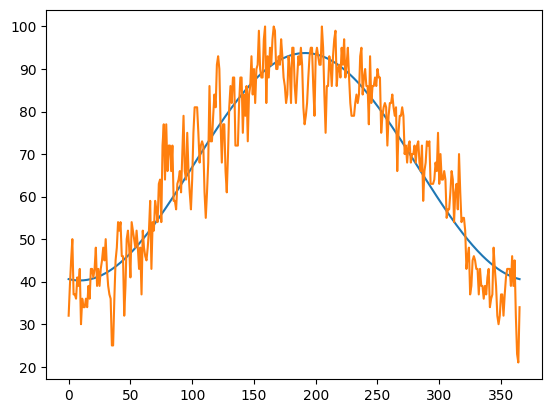

In [243]:
plt.plot(a)
plt.plot(t)

In [454]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import scipy.optimize
import sys
import typing as tp


def seasonal_sin(x, a, b, c):
    y = a + b * np.sin(x * 2 * np.pi / 365 + c)
    return y 


class Predictor:
    def __init__(self, train):
        self.day = len(train)
        self.params, _ = scipy.optimize.curve_fit(seasonal_sin, np.arange(self.day), train)
        self.running_year_delta = 0
            
    def __call__(self, temperature):
        seasonal_pred = seasonal_sin(self.day, *self.params)
        self.day += 1
        alpha = 0.2
        pred = temperature[-1] * (1 - alpha) + seasonal_pred * alpha
        beta = 5e-4
        self.running_year_delta = self.running_year_delta * (1 - beta) + (temperature[-1] - temperature[-365]) * beta
        pred += self.running_year_delta
        pred 
        return pred
        
        
def main(string_io_in=sys.stdin, string_io_out=sys.stdout):
    n_train = int(string_io_in.readline())
    train = [float(string_io_in.readline()) for _ in range(n_train)]
    predictor = Predictor(train)
    n_test = int(string_io_in.readline())
    for _ in range(n_test):
        string_io_out.write(str(predictor(train)) + "\n")
        string_io_out.flush()
        observation = float(string_io_in.readline())
        train.append(observation)


In [455]:
temperature = open("/Users/dimakoshman/Downloads/01.txt").read()

string_io_in = io.StringIO(temperature)
string_io_out = io.StringIO()
main(string_io_in, string_io_out)
preds = np.array(list(map(float, string_io_out.getvalue().split())))

string_io_in = io.StringIO(temperature)
string_io_out = io.StringIO()
train, test = map(np.array, read(string_io_in, string_io_out))

((preds - test)**2).mean()**0.5

6.178733705026372

### [Омографы](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/homographs?currentPage=4&pageSize=10&rowNumber=31)

In [16]:
train_filename = "data/coderun/train.json"
test_filename = "data/coderun/test.json"

write_url_response_content_to_file(
    url=get_yadisk_download_url("https://disk.yandex.ru/d/cKC-mzzsgKdE4Q"),
    filename=train_filename
)
write_url_response_content_to_file(
    url=get_yadisk_download_url("https://disk.yandex.ru/d/it1cLmBxcWh9eg"),
    filename=test_filename
)

In [17]:
train = json.load(open(train_filename))
test = json.load(open(test_filename))

vowels = "аеёиоуыэюя"

def get_word(source):
    for i, word in enumerate(source.split()):
        if word.isupper():
            return i, word.lower()
    raise ValueError(f"No upper word in sentence '{source}'")

for d in train:
    word_id, word = get_word(d["source"])
    target_word = d["target"].split()[word_id]
    word_vowels = [c for c in target_word if c.lower() in vowels]
    vowel_id = [i for i, v in enumerate(word_vowels) if v.isupper()][0]
    d["word"] = word
    d["vowel_id"] = vowel_id
    
for d in test:
    _, word = get_word(d["source"])
    d["word"] = word

In [18]:
checkpoint = "DeepPavlov/rubert-base-cased"
model = transformers.AutoModel.from_pretrained(checkpoint)
tokenizer = transformers.AutoTokenizer.from_pretrained(checkpoint)

set_torch_device_order_pci_bus()
device = "cuda:1"
model = model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
def get_embedding(model, tokenizer, source):
    _, word = get_word(source)
    word_tokens = tokenizer.encode(word, add_special_tokens=False)
    n_word_tokens = len(word_tokens)
    batch_embedding = tokenizer(source.lower(), return_tensors="pt")
    input_ids = batch_embedding.input_ids[0].tolist()
    for i in range(len(input_ids) - n_word_tokens + 1):
        if word_tokens == input_ids[i: i + n_word_tokens]:
            word_start = i
            break
    else:
        raise RuntimeError("Word not found")
    with torch.inference_mode():
        output = model(**batch_embedding.to(device))
    embedding = output.last_hidden_state[0, word_start: word_start + n_word_tokens].mean(0)
    return embedding

In [29]:
train_embeddings = torch.zeros(len(train), model.config.hidden_size, device=device)

for i in tqdm.tqdm(range(len(train))):
    embedding = get_embedding(model, tokenizer, train[i]["source"])
    train_embeddings[i, :] = embedding
    
# torch.save(train_embeddings.to("cpu"), "data/coderun/train_embeddings.pt")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140954/140954 [18:47<00:00, 124.97it/s]


In [116]:
class Normalizer:
    def __init__(self, lang="ru"):
        self.morph = pymorphy3.MorphAnalyzer(lang=lang)
        self.edge_cases = {
            "белок": "белка",
            "больший": "большой",
            "ворон": "ворона",
            "гора": "горе",
            "железо": "железа",
            "леска": "лес",
            "лесок": "лес",
            "роды": "род",
            "толстой": "толстый",
            "узнать": "узнавать",
        }
        
    def __call__(self, word):
        normal_form = self.morph.parse(word)[0].normal_form
        if normal_form in self.edge_cases:
            normal_form = self.edge_cases[normal_form]
        return normal_form

In [117]:
normalizer = Normalizer()
train_ids_by_normal_form = collections.defaultdict(lambda: list())
for i, d in enumerate(tqdm.tqdm(train)):
    normal_form = normalizer(d["word"])
    train_ids_by_normal_form[normal_form].append(i)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140954/140954 [00:18<00:00, 7757.91it/s]


In [134]:
def emphasize(word, vowel_id):
    word = list(word.lower())
    for i, c in enumerate(word):
        if c in vowels:
            if vowel_id == 0:
                word[i] = c.upper()
                word = "".join(word)
                return word
            vowel_id -= 1
    raise ValueError(f"Word {word} has less than {vowel_id + 1} vowels.")

In [135]:
def predict(source, word):
    embedding = get_embedding(model, tokenizer, source)
    candidates = train_ids_by_normal_form[normalizer(word)]
    closest = torch.cosine_similarity(train_embeddings[candidates], embedding).argmax()
    closest = candidates[closest]
    vowel_id = train[closest]["vowel_id"]
    word = emphasize(word, vowel_id)
    return word

In [187]:
preds = []
for i, d in enumerate(tqdm.tqdm(test)):
    try:
        preds.append(predict(**d))
    except Exception as e:
        print(i, type(e), e)
        preds.append(None)

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 12146/17076 [01:45<00:41, 118.73it/s]

<class 'ValueError'> Word ['с', 'а', 'м', 'о', 'м'] has less than 1 vowels.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17076/17076 [02:28<00:00, 115.27it/s]


In [188]:
preds[12128] = "сАмом"
prediciton = "\n".join(preds)

### [Звёздные карты 2.0](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/star-maps-v2?currentPage=4&pageSize=10&rowNumber=32)

In [214]:
dataset_filename = "data/coderun/dataset.zip"

write_url_response_content_to_file(
    url=get_yadisk_download_url("https://disk.yandex.ru/d/Hu-um0ASI6eAUg"),
    filename=dataset_filename
)

n_images = len(os.listdir("data/coderun/dataset"))

In [67]:
def load_image(image_id):
    image_id = f"{image_id:04}"
    image_path = f"data/coderun/dataset/{image_id}.png"
    image = PIL.Image.open(image_path)
    image = image.convert('RGB')
    return image

In [10]:
checkpoint = "microsoft/swinv2-base-patch4-window8-256"
processor = transformers.AutoImageProcessor.from_pretrained(checkpoint)
model = transformers.AutoModel.from_pretrained(checkpoint)

set_torch_device_order_pci_bus()
device = "cuda:1"
model = model.to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at microsoft/swinv2-base-patch4-window8-256 were not used when initializing Swinv2Model: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing Swinv2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Swinv2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
def get_image_embedding(model, processor, image):
    inputs = processor(images=image, return_tensors="pt").to(model.device)
    with torch.inference_mode():
        outputs = model(**inputs)
    embedding = outputs.pooler_output[0]
    return embedding

In [68]:
image_embeddings = torch.zeros(n_images, model.config.hidden_size, device=device)

for i in tqdm.tqdm(range(n_images)):
    image = load_image(i)
    embedding = get_image_embedding(model, processor, image)
    image_embeddings[i, :] = embedding

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9605/9605 [05:39<00:00, 28.30it/s]


In [84]:
import k_means_constrained

kmeans = k_means_constrained.KMeansConstrained(
     n_clusters=983,
     size_min=7,
     size_max=10
)
kmeans.fit(image_embeddings.cpu().numpy())

KMeansConstrained(copy_x=True, init='k-means++', max_iter=300, n_clusters=983,
         n_init=10, n_jobs=1, random_state=None, size_max=10, size_min=7,
         tol=0.0001, verbose=False)

In [93]:
df = pd.DataFrame([(f"{i:04}.png", kmeans.labels_[i]) for i in range(n_images)], columns=["filename", "label"])
df.to_csv("submission.csv", index=False)

### [Иннокентий и друзья](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/eat-spb-msk?currentPage=3&pageSize=10&rowNumber=25)

In [7]:
def batched(iterable, n) -> tp.Generator[list, None, None]:
    """
    Batch data into tuples of length n. The last batch may be shorter.

    batched('ABCDEFG', 3) --> ABC DEF G
    """
    if n < 1:
        raise ValueError("n must be at least one.")

    it = iter(iterable)
    while batch := list(itertools.islice(it, n)):
        yield batch


def torch_tensor_to_scipy_coo(tensor: torch.Tensor) -> scipy.sparse.coo_array:
    if tensor.ndim != 2:
        raise ValueError("Only 2d tensors can be converted to sparse coo arrays.")

    tensor = tensor.detach().cpu().to_sparse_coo().coalesce()
    values = tensor.values().numpy()
    indices = tensor.indices().numpy()
    sparse_coo_array = scipy.sparse.coo_array((values, indices), shape=tensor.shape)
    return sparse_coo_array


def scipy_coo_to_torch_tensor(coo_array: scipy.sparse.coo_array) -> torch.Tensor:
    indices = torch.from_numpy(np.array([coo_array.row, coo_array.col]))
    data = torch.from_numpy(coo_array.data)
    tensor = torch.sparse_coo_tensor(indices=indices, values=data, size=coo_array.shape)
    return tensor


def ratings_to_binary_interaction(user_item_ratings: torch.Tensor) -> torch.Tensor:
    """
    Returns mask indicating whether user has interacted with item.
    The result is different from binary relevance, as for
    example zeros will be treated as valid interactions.
    """
    has_interacted = torch_tensor_to_scipy_coo(user_item_ratings).tocsr()
    has_interacted.data = np.ones_like(has_interacted.data)
    has_interacted = has_interacted.astype(bool)
    has_interacted = scipy_coo_to_torch_tensor(has_interacted.tocoo())
    return has_interacted


def preds_to_recommendations(preds: torch.FloatTensor, k: int) -> torch.IntTensor:
    values, indices = preds.topk(k=k, dim=1)
    return indices


In [115]:
folder = "data/coderun"

rating_cutoff = 4.2
n_reviews_cutoff = 100

reviews = pd.read_csv(os.path.join(folder, "reviews.csv"))
users = pd.read_csv(os.path.join(folder, "users.csv"))
orgs = pd.read_csv(os.path.join(folder, "organisations.csv"))
test_users = list(pd.read_csv(os.path.join(folder, "test_users.csv"))["user_id"].values)
orgs = orgs[orgs["rating"] >= rating_cutoff]

reviews = reviews.dropna(subset=["rating"])

groupby = reviews.groupby("org_id")["rating"].mean()
reviews = reviews[reviews["org_id"].isin(groupby[groupby >= rating_cutoff].index)]

groupby = reviews.groupby("org_id")["rating"].count()
reviews = reviews[reviews["org_id"].isin(groupby[groupby >= n_reviews_cutoff].index)]

reviews = reviews[reviews["org_id"].isin(orgs["org_id"])]

orgs = orgs[orgs["org_id"].isin(reviews["org_id"])]
all_users = sorted(set(reviews["user_id"]) | set(test_users))
users = users[users["user_id"].isin(all_users)]

In [116]:
msk_users = users[users["city"] == "msk"]["user_id"].values
spb_users = users[users["city"] == "spb"]["user_id"].values

msk_orgs = orgs[orgs["city"] == "msk"]["org_id"].values
spb_orgs = orgs[orgs["city"] == "spb"]["org_id"].values

msk_reviews = reviews[reviews["org_id"].isin(msk_orgs) & reviews["user_id"].isin(msk_users)]
spb_reviews = reviews[reviews["org_id"].isin(spb_orgs) & reviews["user_id"].isin(spb_users)]

In [117]:
def build_review_matrix(reviews):
    user_encoder = sklearn.preprocessing.LabelEncoder()
    users = user_encoder.fit_transform(reviews["user_id"].values)

    item_encoder = sklearn.preprocessing.LabelEncoder()
    items = item_encoder.fit_transform(reviews["org_id"].values)
    
    n_users = len(user_encoder.classes_)
    n_items = len(item_encoder.classes_)

    rating = reviews["rating"].values
    matrix = scipy.sparse.csr_array((rating, (users, items)) , shape=(n_users, n_items))
    
    return matrix, user_encoder, item_encoder

In [118]:
msk_matrix, msk_user_encoder, msk_item_encoder = build_review_matrix(msk_reviews)
spb_matrix, spb_user_encoder, spb_item_encoder = build_review_matrix(spb_reviews)

In [119]:
def generate_base_recs(matrix, test_users, n_components=100, n_recs=100):
    torch_matrix = scipy_coo_to_torch_tensor(matrix.tocoo())
    user_item_interactions = ratings_to_binary_interaction(torch_matrix)
    user_item_interactions = torch_tensor_to_scipy_coo(user_item_interactions).tocsr()

    tsvd = sklearn.decomposition.TruncatedSVD(n_components=n_components)
    tsvd.fit(matrix)

    ratings = matrix[test_users]
    embedding = tsvd.transform(ratings)
    preds = tsvd.inverse_transform(embedding)
    preds = torch.from_numpy(preds)

    is_known_item = user_item_interactions[test_users]
    is_known_item = torch.from_numpy(is_known_item.todense())
    preds = torch.where(is_known_item, -torch.inf, preds)

    recommendations = preds_to_recommendations(preds, k=n_recs).numpy()
    
    return recommendations

In [120]:
known_test_msk_users = sorted(set(test_users) & set(msk_user_encoder.classes_))
known_test_spb_users = sorted(set(test_users) & set(spb_user_encoder.classes_))
unknown_msk_users = sorted(set(test_users) & set(msk_users) - set(known_test_msk_users))
unknown_spb_users = sorted(set(test_users) & set(spb_users) - set(known_test_spb_users))

In [121]:
msk_preds = generate_base_recs(msk_matrix, msk_user_encoder.transform(known_test_msk_users))
spb_preds = generate_base_recs(spb_matrix, spb_user_encoder.transform(known_test_spb_users))

In [122]:
msk_orgs_df = orgs[orgs["city"] == "msk"]
msk_orgs_df = msk_orgs_df.set_index("org_id")
msk_orgs_df = msk_orgs_df.loc[msk_item_encoder.classes_]
msk_orgs_df["popularity"] = msk_matrix.sum(0)
msk_top_orgs = list((msk_orgs_df["rating"] * np.log(msk_orgs_df["popularity"])).sort_values().index[-100:][::-1])

spb_orgs_df = orgs[orgs["city"] == "spb"]
spb_orgs_df = spb_orgs_df.set_index("org_id")
spb_orgs_df = spb_orgs_df.loc[spb_item_encoder.classes_]
spb_orgs_df["popularity"] = spb_matrix.sum(0)
spb_top_orgs = list((spb_orgs_df["rating"] * np.log(spb_orgs_df["popularity"])).sort_values().index[-100:][::-1])

In [126]:
tu = known_test_msk_users + known_test_spb_users + unknown_msk_users + unknown_spb_users
tp = ([spb_top_orgs for _ in range(len(known_test_msk_users))]
      + [msk_top_orgs for _ in range(len(known_test_spb_users))]
      + [spb_top_orgs for _ in range(len(unknown_msk_users))]
      + [msk_top_orgs for _ in range(len(unknown_spb_users))])
for i in tp:
    assert len(i) == 100

In [127]:
submission = pd.DataFrame()
submission["user_id"] = tu
submission["target"] = tp
submission.to_csv("submission.csv", index=False)